# Creating Ainos initial model and input files for DENISE

Jupyter notebook for the definition of FD model and modelling/FWI/RTM parameters of DENISE Black-Edition. For a more detailed explanation of the parameters, I refer to the [DENISE Black-Edition user manual](https://danielkoehnsite.files.wordpress.com/2021/06/manual_denise.pdf)

Daniel Koehn

Kiel, 12.01.2023

In [1]:
# Import Python libaries 
# ----------------------
import numpy as np                         # NumPy library
from denise_SH_IO.denise_sh_out import *   # "DENISE" library

## Estimate initial S-wave velocity model from FA picks

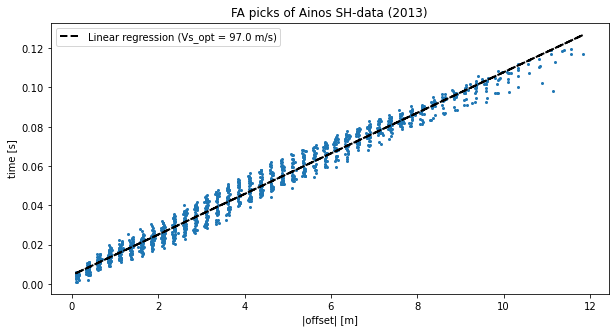

In [2]:
# basename of FA pick files
picks_base = "../002_DENISE_Ainos_data_init_model/Ainos_data_FA_SH_picks_daniel/picks_TW2_"

# number of shots
nshots = 48

# read offsets and FA times from pick files
for i in range(1,nshots+1):

    pickfilename = picks_base + str(i) + ".dat"
    tmp = np.loadtxt(pickfilename, delimiter='\t', skiprows=0, unpack='False')
    
    if(i==1):
        offset = tmp[0]
        FA_times = tmp[1]
    if(i>1):
        offset = np.concatenate((offset, tmp[0]), axis=0) 
        FA_times = np.concatenate((FA_times, tmp[1]), axis=0) 

# linear regression with NumPy to estimate optimum S-wave slowness s_opt and t_0:
s_opt, t_0 = np.polyfit(np.abs(offset), FA_times, 1)
f_linear = np.poly1d((s_opt, t_0))         

# convert optimum slowness -> velocity
vs_opt = 1/s_opt

# plot FA picks  
fig = plt.figure(figsize=(10., 5.))
plt.plot(np.abs(offset), FA_times,'o', markersize=2)

# plot linear regression
reg_label = 'Linear regression (Vs_opt = ' + str(np.round(vs_opt)) + ' m/s)'
plt.plot(np.abs(offset), f_linear(np.abs(offset)), 'k--', linewidth=2, label=reg_label)

# add legend and labels
plt.xlabel('|offset| [m]')
plt.ylabel('time [s]')
plt.title('FA picks of Ainos SH-data (2013)')
plt.legend()

# save figure as pdf
plt.savefig('FA_picks_linear_fit.pdf', bbox_inches='tight', format='pdf')

Let's compare the estimate average S-wave velocity from your FA picks with the "optimum" S-wave velocity estimated in [Schwardt et al. 2020](https://onlinelibrary.wiley.com/doi/10.1002/nsg.12097).

## Create DENISE Black-Edition input files

## 1. Short description of modelling/FWI problem 

Define name of **DENISE parameter file**

In [3]:
para["filename"] = "DENISE_ainos_fwi.inp"

Give a short **description** of your modelling/FWI problem

In [4]:
para["descr"] = "Ainos 1st FWI"

What kind of **PHYSICS** do you want to use? (2D-PSV=1; 2D-AC=2; 2D-PSV-VTI=3; 2D-PSV-TTI=4; 2D-SH=5)

In [5]:
para["PHYSICS"] = 5

Choose DENISE operation mode (**MODE**): (forward_modelling_only=0; FWI=1; RTM=2)

In [6]:
para["MODE"] = 1

## 2. Define 2D visco-elastic inital model for Ainos FWI

First define spatial model discretization:

In [7]:
para["NX"] = 280     # number of grid points in x-direction
para["NY"] = 280     # number of grid points in y-direction
para["DH"] = 0.05    # spatial grid point distance [m]

Define visco-elastic SH model:

In [8]:
vs0 = 100.   # homogeneous S-wave velocity of the half-space [m/s]
rho0 = 1800. # homogeneous density of the half-space [kg/m^3] 
Qs0 = 25.0   # homogeneous Qs of the half-space [] 

# define models
vs  = vs0 * np.ones((para["NY"],para["NX"]))
rho  = rho0 * np.ones((para["NY"],para["NX"]))
Qs  = Qs0 * np.ones((para["NY"],para["NX"]))

# apply flipud to models
vs = np.flipud(vs)
rho = np.flipud(rho)
Qs = np.flipud(Qs)

Define coordinate axis

In [9]:
x = np.arange(para["DH"], para["DH"] * (para["NX"] + 1), para["DH"])
y = np.arange(para["DH"], para["DH"] * (para["NY"] + 1), para["DH"])

Plot external model

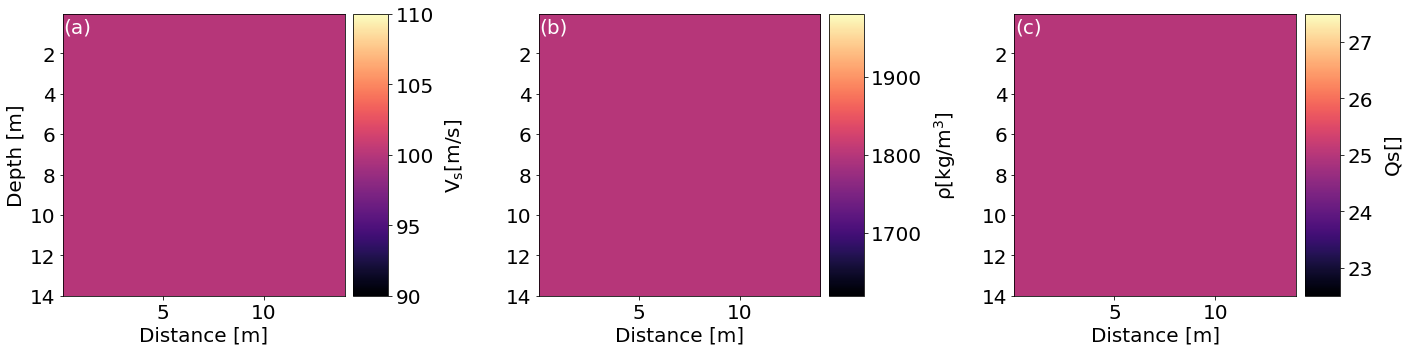

In [10]:
cmap = "magma"  # colormap

# define minimum and maximum material parameter values
vsmin = np.min(vs) 
vsmax = np.max(vs)

rhomin = np.min(rho) 
rhomax = np.max(rho)

Qsmin = np.min(Qs) 
Qsmax = np.max(Qs)

# plot visco-elastic model
plot_model(vs,rho,Qs,x,y,cmap,vsmin,vsmax,rhomin,rhomax,Qsmin,Qsmax,20,5)

Write model to IEEE-le binary file

In [11]:
# model basename
model_basename = "Ainos_visc_hom_init"

# location of model files during DENISE forward modelling run
para["MFILE"] = "start/" + model_basename

# writing S-wave velocity model to IEEE-le binary file
name_model = model_basename + ".vs"
f = open (name_model, mode='wb')
data_type = np.dtype ('float32').newbyteorder ('<')
vs1 = np.array(vs, dtype=data_type)
vs1 = np.rot90(vs1,3)
vs1.tofile(f)
f.close()

# writing density model to IEEE-le binary file
name_model = model_basename + ".rho"
f = open (name_model, mode='wb')
data_type = np.dtype ('float32').newbyteorder ('<')
rho1 = np.array(rho, dtype=data_type)
rho1 = np.rot90(rho1,3)
rho1.tofile(f)
f.close()

# writing Qs model to IEEE-le binary file
name_model = model_basename + ".qs"
f = open (name_model, mode='wb')
data_type = np.dtype ('float32').newbyteorder ('<')
qs1 = np.array(Qs, dtype=data_type)
qs1 = np.rot90(qs1,3)
qs1.tofile(f)
f.close()

To check if the models are correctly written to the binary files, you can use the Seismic Unix function `ximage`

In [12]:
print("ximage n1=" + str(para["NY"]) + " < " + model_basename + ".vs")
print("ximage n1=" + str(para["NY"]) + " < " + model_basename + ".rho")
print("ximage n1=" + str(para["NY"]) + " < " + model_basename + ".qs")

ximage n1=280 < Ainos_visc_hom_init.vs
ximage n1=280 < Ainos_visc_hom_init.rho
ximage n1=280 < Ainos_visc_hom_init.qs


## 3. Define spatial FD operator

Spatial FD operator coefficients are based on [Taylor series expansion](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/04_FD_stability_dispersion/3_fd_taylor_operators.ipynb) and optimized according to [Holberg (1987)](http://www.earthdoc.org/publication/publicationdetails/?publication=35061) 

In [15]:
# Order of spatial FD operator (2, 4, 6, 8, 10, 12)
para["FD_ORDER"] = 2

# Maximum relative group velocity error E
# (minimum number of grid points per shortest wavelength is defined by FD_ORDER and E)
# values: 
# 0 = Taylor coefficients
# 1 = Holberg coeff.: E = 0.1 %
# 2 =                 E = 0.5 %
# 3 =                 E = 1.0 %
# 4 =                 E = 3.0 %
para["max_relative_error"] = 2

Estimate the maximum frequency in the source wavelet, which can be modelled by the given FD grid discretization and spatial FD operator, using the [grid dispersion citerion](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/04_FD_stability_dispersion/1_fd_stability_dispersion.ipynb)

In [16]:
# maximum modelling frequency based on grid dispersion criterion for spatial FD operator
freqmax = calc_max_freq(vs,para)

Minimum Vs:  100.0  m/s
no of gridpoints per minimum wavelength =  22.2
maximum source wavelet frequency =  90.09009009009009  Hz


If you want to model higher frequency wave propagation, you have to decrease the spatial gridpoint distance DH by resampling the model

## 4. Parallelization by Domain Decomposition

In [17]:
para["NPROCX"] = 8  # number of processors in x-direction
para["NPROCY"] = 8  # number of processors in y-direction

Check if the spatial domain decomposition is consistent with the spatial FD grid discretization. The following conditions have to be satisfied

NX % NPROCX = 0

NY % NPROCY = 0

In [18]:
check_domain_decomp(para)

Domain decomposition in x-direction is correct NX % NPROCX = 0
Domain decomposition in y-direction is correct NY % NPROCY = 0


If the domain decomposition conditions are not satisfied, you have to add additional gridpoints at the bottom and right model boundary.

## 5. Time stepping

Calculate maximum time step **DT** according to the [Courant-Friedrichs-Lewy (CFL) criterion](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/04_FD_stability_dispersion/1_fd_stability_dispersion.ipynb)

In [19]:
para["DT"] = check_stability(vs,para)

Maximum Vs:  100.0  m/s
According to the Courant-Friedrichs-Lewy (CFL) criterion
the maximum time step is DT = 3.52e-04 s


If you want to apply a FWI, keep in mind that the FWI will change the velocity model. Therefore, the maxium seismic velocities in the model will increase and you should choose a smaller time step than the DT derived from the CFL criterion

In [20]:
para["TIME"] = 0.5    # time of wave propagation [s]
para["DT"] = 1.7e-4   # timestep [s]

## 6. Q-approximation

In [21]:
para["L"] = 3     # number of relaxation mechanisms
para["FL"] = 40.  # relaxation frequencies [Hz]    

## 7. Boundary conditions 

Define boundary conditions. **FREE_SURF=1** activates a free-surface boundary condition at y = 0 m. PML absorbing boundaries according to [Komatitsch & Martin (2007)](https://www.researchgate.net/publication/47503800_An_unsplit_convolutional_Perfectly_Matched_Layer_improved_at_grazing_incidence_for_the_seismic_wave_equation) are defined by their width **FW**, damping velocity **DAMPING**, damping frequency **FPML**, degree of damping profile **npower** and **k_max_PML** 

In [22]:
# free surface boundary condition
para["FREE_SURF"] = 1      # activate free surface boundary condition

# PML boundary frame
para["FW"] = 10
para["DAMPING"] = 64.
para["FPML"] = 30.
para["npower"] = 2.
para["k_max_PML"] = 7.

## 8. Define acquisition geometry

### a) Receiver properites and positions
Place receivers on FD modelling grid

In [23]:
# read receiver positions from receiver file
basename_rec = 'receiver_ainos_SH'
recfilename = '../001_BIRGIT_Ainos_data_import/receiver/' + basename_rec + '.dat'
tmp = np.loadtxt(recfilename, delimiter='\t', skiprows=0, unpack='False')
xrec = tmp[0]
yrec = tmp[1]

Check if receivers are located in computational domain and **not** the PMLs

In [24]:
check_src_rec_pml(xrec,yrec,para,1)

No receivers in the PML boundary frame - test passed


Define type of seismograms **SEISMO**:

SEISMO=0: no seismograms

SEISMO=1: particle-velocities

SEISMO=2: pressure (hydrophones)

SEISMO=3: curl and div

SEISMO=4: everything

In [25]:
# type of seismogram
para["SEISMO"] = 1

How does DENISE read receiver positions from a file? In case of a fixed spread geometry you only need a single receiver file (READREC=1). If you want to model streamer geometry or more generally variable acquisition geometry with changing receiver positions for each shot, you have to define a separate receiver file for each shot (READREC=2)

In [26]:
para["READREC"] = 1

Define location and basename of receiver file, defined above, _without_ ".dat" extension 

In [27]:
para["REC_FILE"] = "./receiver/" + basename_rec

Define the seismogram properties

In [28]:
para["NDT"] = 1   # seismogram sampling rate in timesteps (has to be set to NDT=1 if you run FWI)

# location and name of seismogram output files in SU format

# particle velocities (if SEISMO=1 or SEISMO=4)
para["SEIS_FILE_VX"] = "su/DENISE_ainos_x.su"  # filename for vx component
para["SEIS_FILE_VY"] = "su/DENISE_ainos_y.su"  # filename for vy component

# curl and div of wavefield (if SEISMO=3 or SEISMO=4)
para["SEIS_FILE_CURL"] = "su/DENISE_ainos_rot.su"  # filename for rot_z component ~ S-wave energy
para["SEIS_FILE_DIV"] = "su/DENISE_ainos_div.su"   # filename for div component ~ P-wave energy

# pressure field (hydrophones) (if SEISMO=2 or SEISMO=4)
para["SEIS_FILE_P"] = "su/DENISE_ainos_p.su"  # filename for pressure component

### b) Source properties and positions

Read source coordinates from source file

In [29]:
# read source positions from source file
basename_src = 'source_ainos_SH.dat'
recfilename = '../001_BIRGIT_Ainos_data_import/source/' + basename_src
tmp = np.loadtxt(recfilename, delimiter='\t', skiprows=1, unpack='False')
xsrc = tmp[0]
ysrc = tmp[2]
nshot = len(ysrc)

Check if sources are located in computational domain and **not** the PMLs

In [30]:
check_src_rec_pml(xsrc,ysrc,para,2)

No sources in the PML boundary frame - test passed


Define location of the source file:

In [31]:
para["SOURCE_FILE"] = "./source/" + basename_src

Do you want to excite all source positions simultaneously (**RUN_MULTIPLE_SHOTS=0**) or start a separate modelling run for each shot (**RUN_MULTIPLE_SHOTS=1**)

In [32]:
para["RUN_MULTIPLE_SHOTS"] = 1

Define shape of the source signal (**QUELLART**)

- **Ricker** wavelet = 1

\begin{equation}
\rm{r(\tau)=\left(1-2\tau^2\right)\exp(-\tau^2)} \quad \mbox{with} \quad \rm{\tau=\frac{\pi(t-1.5/f_c-t_d)}{1.0/f_c}}
\label{eq_ricker}
\end{equation}

- **Fuchs-Mueller** wavelet = 2

\begin{equation}
\rm{f_m(t)=\sin(2\pi(t-t_d)f_c)-0.5\sin(4\pi(t-t_d)f_c)} \quad \mbox{if} \quad \rm{t\in[t_d,t_d+1/fc]} \quad \mbox{else} \quad \rm{fm(t)=0}
\label{eq_fm}
\end{equation}

- **read wavelet from ASCII file** = 3

- **SIN^3** wavelet = 4

\begin{equation}
\rm{s3(t)=0.75 \pi f_c \sin(\pi(t+t_d)f_c)^3}\quad \mbox{if} \quad \rm{t \in[t_d,t_d+1/fc]} \quad \mbox{else} \quad \rm{s3(t)=0}
\label{eq_s3}
\end{equation}

- **Gaussian derivative** wavelet = 5 

\begin{equation}
\rm{gd(t)=-2 \pi^2 f_c^2 (t-t_d) exp(-\pi^2 f_c^2 (t-t_d)^2)}
\label{eq_s4}
\end{equation}

- **Bandlimited spike** wavelet = 6

- **Klauder** wavelet = 7

\begin{equation}
\rm{klau(t) = real\biggl\{sin\biggl(\frac{\pi k \tau (TS-\tau)}{\pi k \tau}\biggr)(exp(2 \pi i f_0 \tau))\biggr\}} \quad \mbox{with} \quad \rm{\tau=(t-1.5/FC\_SPIKE\_1-t_d)}\}
\label{eq_s5}
\end{equation}

   with

   $\rm{k=(FC\_SPIKE\_2-FC\_SPIKE\_1)/TS}$ (rate of change of frequency with time)

   $\rm{f_0=(FC\_SPIKE\_2+FC\_SPIKE\_1)/2}$ (midfrequency of bandwidth)

   $\rm{i^2=-1}$

In these equations, t denotes time and $f_c$ is the center frequency. $t_d$ is a time delay which can be defined for each source position in SOURCE\_FILE. Note that the symmetric (zero phase) Ricker signal is always delayed by $1.0/f_c$, which means that after one period the maximum amplitude is excited at the source location.

In [33]:
para["QUELLART"] = 6

If you read the wavelet from an ASCII file (**QUELLART=3**), you have to define the location of the signal file (SIGNAL_FILE)

In [34]:
para["SIGNAL_FILE"] = "./wavelet/wavelet_ainos"

In case of the **bandlimited spike** wavelet you have to define ...

- If FC_SPIKE_1 <= 0.0 a low-pass filtered spike with upper corner frequency FC_SPIKE_2 and order ORDER_SPIKE is calculated

- If FC_SPIKE_1 > 0.0 a band-pass filtered spike with lower corner frequency FC_SPIKE_1 and upper corner frequency FC_SPIKE_2 with order ORDER_SPIKE is calculated

In [35]:
para["FC_SPIKE_1"] = -5.0    # lower corner frequency [Hz]
para["FC_SPIKE_2"] = 150.0   # upper corner frequency [Hz]

# you can also use the maximum frequency computed from the grid dispersion 
# criterion in section 3. based on spatial discretization and FD operator
# para["FC_SPIKE_2"] = freqmax # upper corner frequency [Hz]

para["ORDER_SPIKE"] = 6      # order of Butterworth filter

In case of the **Klauder wavelet** you have to define the sweep length **TS**

In [36]:
para["TS"] = 8.0  # sweep length [s]

Do you want to write the source wavelet to a SU file for each shot (**WRITE_STF=1**)? 

In [37]:
para["WRITE_STF"] = 1

Plot acquisition geometry relative to the subsurface model. Red stars denote the source positions and cyan triangles receiver positions

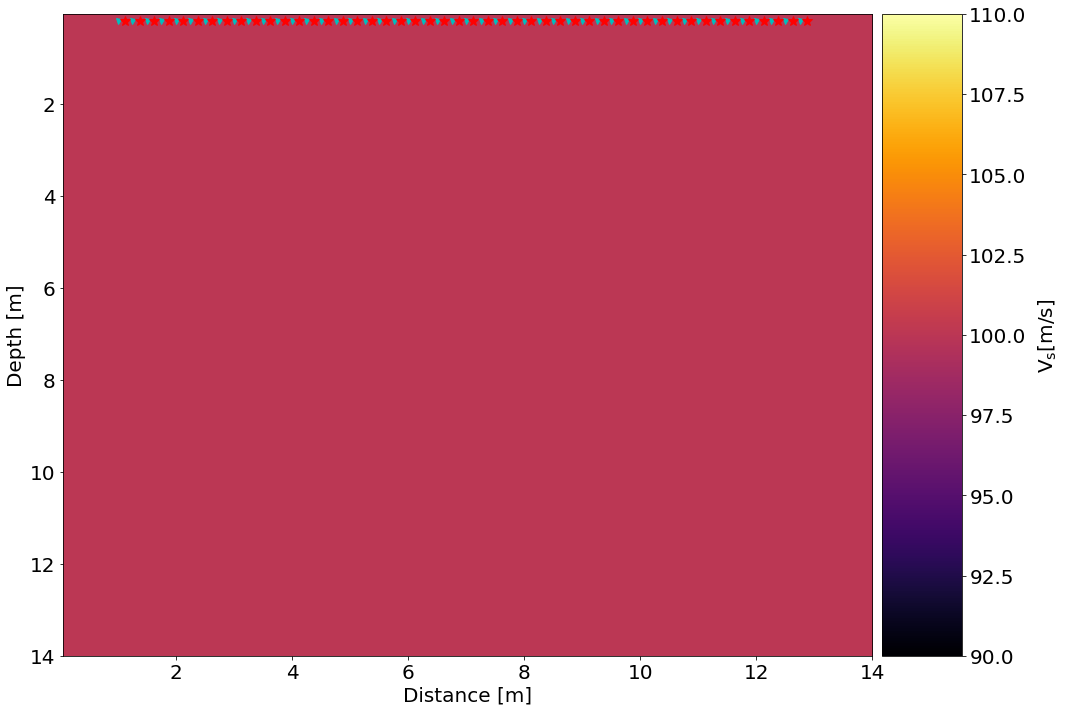

In [38]:
cmap = "inferno"
plot_acq(vs,xrec,yrec,xsrc,ysrc,x,y,cmap,vsmin,vsmax)

## 9. Wavefield snapshots 

Output of wavefield snapshots (**SNAP>0**):

- **particle velocities**: SNAP=1
- **pressure field**: SNAP=2
- **curl and divergence energy**: SNAP=3
- both **particle velocities and energy** : SNAP=4

In [39]:
para["SNAP"] = 0  
para["SNAP_SHOT"] = 1     # compute and  write snapshots for shot no. SNAP_SHOT

para["TSNAP1"] = para["DT"]  # first snapshot [s] (TSNAP1 has to fullfill the condition TSNAP1 > DT)
para["TSNAP2"] = 0.5         # first snapshot [s]
para["TSNAPINC"] = 0.01      # snapshot increment [s]

para["IDX"] = 1              # write only every IDX spatial grid point in x-direction to snapshot file
para["IDY"] = 1              # write only every IDY spatial grid point in y-direction to snapshot file

para["SNAP_FILE"] = "./snap/waveform_forward"  # location and basename of the snapshot files

## 10. Log file name

In [40]:
para["LOG_FILE"] = "log/Ainos_SH.log"  # Log file name

## FWI parameters

If you only want to run FD forward modelling runs, you can neglect the parameters below, which are fixed FWI parameters

## 11. General FWI parameters

In [41]:
para["ITERMAX"] = 600   # maximum number of TDFWI iterations at each FWI stage defined in FWI workflow file

para["JACOBIAN"] = "jacobian/gradient_Test"              # location and basename of FWI gradients 
para["DATA_DIR"] = "su/Ainos/DENISE_ainos"   # location and basename of field data seismograms

para["INVMAT1"] = 1 # material parameterization for FWI (Vp,Vs,rho=1/Zp,Zs,rho=2/lam,mu,rho=3)
# Currently, only the Vp-Vs-rho parametrization (INVMAT1=1) can be used

para["GRAD_FORM"] = 2 # gradient formulation (time integration of adjoint sources = 1, no time integration = 2)

# Adjoint source type
# x-y components = 1; y-comp = 2; x-comp = 3; p-comp = 4; x-p-comp = 5; y-p-comp = 6; x-y-p-comp = 7
# Notice: If PHYSICS=5 (SH-Mode) QUELLTYPB = 1 denotes a source excitation in z-direction
para["QUELLTYPB"] = 1 

# Optimization method
para["GRAD_METHOD"] = 1    # PCG = 1; LBFGS = 2

# PCG_BETA (Fletcher_Reeves=1/Polak_Ribiere=2/Hestenes_Stiefel=3/Dai_Yuan=4)
para["PCG_BETA"] = 2

# store NLBFGS update during LBFGS optimization
para["NLBFGS"] = 20

# store wavefields only every DTINV time sample for gradient computation
para["DTINV"] = 7

# FWI log file location and name
para["MISFIT_LOG_FILE"] = "Ainos_fwi_log.dat"

## 12. FWI gradient taper functions

In [42]:
# gradient taper geometry
para["GRADT1"] = 21
para["GRADT2"] = 25
para["GRADT3"] = 490
para["GRADT4"] = 500
para["TAPERLENGTH"] = (int)(para["GRADT2"]-para["GRADT1"])

# apply vertical taper (SWS_TAPER_GRAD_VERT=1)
para["SWS_TAPER_GRAD_VERT"] = 0

# apply horizontal taper (SWS_TAPER_GRAD_HOR=1)
para["SWS_TAPER_GRAD_HOR"] = 0

# exponent of depth scaling for preconditioning
para["EXP_TAPER_GRAD_HOR"] = 0.0

# Circular taper around all sources (not at receiver positions)
para["SWS_TAPER_GRAD_SOURCES"] = 0
para["SWS_TAPER_CIRCULAR_PER_SHOT"] = 0 
para["SRTSHAPE"] = 1    # SRTSHAPE: 1 = error_function; 2 = log_function
para["SRTRADIUS"] = 5.  # --> minimum for SRTRADIUS is 5x5 gridpoints

# Read taper file from external file
para["SWS_TAPER_FILE"] = 0

# Basename for taper file
para["TFILE"] = "taper/taper"   # location of taper function

## 13. FWI model output

In [43]:
# model location and basename
para["INV_MODELFILE"] = "model/modelTest"

# write inverted model after each iteration (yes=1)? 
# Warning: Might require a lot of disk space
para["INV_MOD_OUT"] = 0

## 14. Bound constraints

Upper and lower limits for different model parameter classes

In [44]:
# upper limit for vp
para["VPUPPERLIM"] = 6000.

# lower limit for vp
para["VPLOWERLIM"] = 0.

# upper limit for vs
para["VSUPPERLIM"] = 800.

# lower limit for vs
para["VSLOWERLIM"] = 30.

# upper limit for density
para["RHOUPPERLIM"] = 3000.

# lower limit for density
para["RHOLOWERLIM"] = 1000.

# upper limit for Qs
para["QSUPPERLIM"] = 100.

# lower limit for Qs
para["QSLOWERLIM"] = 10.

## 15. Step length estimation

In [45]:
para["EPS_SCALE"] = 0.01   # initial model update during step length estimation 
para["STEPMAX"] = 6        # maximum number of attemps to find a step length during line search
para["SCALEFAC"] = 2.      # scale step during line search

# evaluate objective function only for a limited number of shots
para["TESTSHOT_START"] = 1
para["TESTSHOT_END"] = 48
para["TESTSHOT_INCR"] = 2

Check step length estimation

In [46]:
check_steplength(nshot,para)

Step length check - passed


## 16. Trace muting

In [47]:
# Activate trace muting (yes=1)
para["TRKILL"] = 0

# Location and name of trace mute file containing muting matrix
para["TRKILL_FILE"] = "./trace_kill/trace_kill.dat"

## 17. Time damping

In [48]:
# Basename of picked traveltimes for each shot
# Time damping parameters are defined in the DENISE 
# workflow file for each FWI stage
para["PICKS_FILE"] = "./picked_times/picks_"

## 18. Apply 2D Median Filter to Models

In [49]:
# Remove source/receiver artifacts by 2D spatial median filtering of models
para["MODEL_FILTER"] = 1
para["FILT_SIZE"] = 10

## 19. Apply 2D Median Filter to Gradients

In [50]:
# Remove source/receiver artifacts by 2D spatial median filtering of gradients
para["GRAD_FILTER"] = 0
para["FILT_SIZE_GRAD"] = 5

## 20. Minimum number of Iterations/FWI-Stage

In [51]:
# Minimum number of iterations per FWI stage
para["MIN_ITER"] = 8

## 21. Create DENISE parameter file

In [52]:
write_denise_para(para)

# Define FWI workflow file

If you want to run a FWI, you also have to define a FWI workflow file ...

Define name of **DENISE FWI workflow file**

In [53]:
para["filename_workflow"] = "FWI_workflow_ainos_SH.inp"

Create Header for DENISE FWI workflow file

In [54]:
write_denise_workflow_header(para)

## 1. FWI parameters for each inversion stage 

For each inversion stage copy the cell below and define the FWI parameters. For a detailed description of the FWI workflow parameters, I refer to the user manual. "Experimental" options should be used with care and are still buggy. 

In [55]:
# Define FWI parameters for stage 1 ...

# Termination criterion
para["PRO"] = 0.01

# Frequency filtering
# TIME_FILT = 0 (apply no frequency filter to field data and source wavelet)
# TIME_FILT = 1 (apply low-pass filter to field data and source wavelet)
# TIME_FILT = 2 (apply band-pass filter to field data and source wavelet)
para["TIME_FILT"] = 1

# Low- (FC_LOW) and high-pass (FC_HIGH) corner frequencies of Butterworthfilter
# of order ORDER
para["FC_LOW"] = 0.0
para["FC_HIGH"] = 10.0
para["ORDER"] = 6

# Time windowing
para["TIME_WIN"] = 0
para["GAMMA"] = 20.0
para["TWIN-"] = 0.0
para["TWIN+"] = 0.0

# Starting FWI of parameter class Vp, Vs, rho, Qs from iteration number 
# INV_VP_ITER, INV_VS_ITER, INV_RHO_ITER, INV_QS_ITER
para["INV_VP_ITER"] = 0
para["INV_VS_ITER"] = 0
para["INV_RHO_ITER"] = 600
para["INV_QS_ITER"] = 600

# Apply spatial Gaussian filter to gradients 
# SPATFILTER = 0 (apply no filter)
# SPATFILTER = 2 (Wavenumber filter)
# SPATFILTER = 4 (Anisotropic Gaussian filter with half-width adapted to the local wavelength)
para["SPATFILTER"] = 2

# If Gaussian filter (SPATFILTER=4), define the fraction of the local wavelength in ...
# x-direction WD_DAMP and y-direction WD_DAMP1 used to define the half-width of the 
# Gaussian filter
para["WD_DAMP"] = 4
para["WD_DAMP1"] = 4

# Preconditioning of the gradient directions
# EPRECOND = 0 - no preconditioning
# EPRECOND = 1 - approximation of the Pseudo-Hessian (Shin et al. 2001)
# EPRECOND = 3 - Hessian approximation according to Plessix & Mulder (2004)
para["EPRECOND"] = 3

# Define objective function
# LNORM = 2 - L2 norm
# LNORM = 5 - global correlation norm (Choi & Alkhalifah 2012)
# LNORM = 6 - envelope objective functions after Chi, Dong and Liu (2014) - EXPERIMENTAL
# LNORM = 7 - NIM objective function after Chauris et al. (2012) and Tejero et al. (2015) - EXPERIMENTAL
para["LNORM"] = 5

# Activate Random Objective Waveform Inversion (ROWI, Pan & Gao 2020)
# ROWI = 0 - no ROWI
# ROWI = 1 - 50% GCN l2 norm / 50% AGC l2 norm (AC, PSV, SH modules only)
para["ROWI"] = 0

# Source wavelet inversion
# STF = 0 - no source wavelet inversion
# STF = 1 - estimate source wavelet by stabilized Wiener Deconvolution 
para["STF"] = 1

# If OFFSETC_STF > 0, limit source wavelet inversion to maximum offsets OFFSETC_STF
para["OFFSETC_STF"] = 2.2

# Source wavelet inversion stabilization term to avoid division by zero in Wiener Deco
para["EPS_STF"] = 1.5e-1

# Apply Offset mute to field and modelled seismograms
# OFFSET_MUTE = 0 - no offset mute
# OFFSET_MUTE = 1 - mute far-offset data for offset >= OFFSETC
# OFFSET_MUTE = 1 - mute near-offset data for offset <= OFFSETC
para["OFFSET_MUTE"] = 0
para["OFFSETC"] = 5.

# Scale density and Qs updates during multiparameter FWI by factors 
# SCALERHO and SCALEQS, respectively
para["SCALERHO"] = 0.5
para["SCALEQS"] = 1.0

# If LNORM = 6, define type of envelope objective function (EXPERIMENTAL)
# ENV = 1 - L2 envelope objective function
# ENV = 2 - Log L2 envelope objective function
para["ENV"] = 1

# Integrate synthetic and modelled data NORDER times (EXPERIMENTAL)
para["N_ORDER"] = 0

# Write parameters to DENISE workflow file
write_denise_workflow(para)

In [56]:
# Define FWI parameters for stage 2 ...

# Termination criterion
para["PRO"] = 0.01

# Frequency filtering
# TIME_FILT = 0 (apply no frequency filter to field data and source wavelet)
# TIME_FILT = 1 (apply low-pass filter to field data and source wavelet)
# TIME_FILT = 2 (apply band-pass filter to field data and source wavelet)
para["TIME_FILT"] = 1

# Low- (FC_LOW) and high-pass (FC_HIGH) corner frequencies of Butterworthfilter
# of order ORDER
para["FC_LOW"] = 0.0
para["FC_HIGH"] = 15.0
para["ORDER"] = 6

# Time windowing
para["TIME_WIN"] = 0
para["GAMMA"] = 20.0
para["TWIN-"] = 0.0
para["TWIN+"] = 0.0

# Starting FWI of parameter class Vp, Vs, rho, Qs from iteration number 
# INV_VP_ITER, INV_VS_ITER, INV_RHO_ITER, INV_QS_ITER
para["INV_VP_ITER"] = 0
para["INV_VS_ITER"] = 0
para["INV_RHO_ITER"] = 600
para["INV_QS_ITER"] = 600

# Apply spatial Gaussian filter to gradients 
# SPATFILTER = 0 (apply no filter)
# SPATFILTER = 2 (Wavenumber filter)
# SPATFILTER = 4 (Anisotropic Gaussian filter with half-width adapted to the local wavelength)
para["SPATFILTER"] = 2

# If Gaussian filter (SPATFILTER=4), define the fraction of the local wavelength in ...
# x-direction WD_DAMP and y-direction WD_DAMP1 used to define the half-width of the 
# Gaussian filter
para["WD_DAMP"] = 4
para["WD_DAMP1"] = 4

# Preconditioning of the gradient directions
# EPRECOND = 0 - no preconditioning
# EPRECOND = 1 - approximation of the Pseudo-Hessian (Shin et al. 2001)
# EPRECOND = 3 - Hessian approximation according to Plessix & Mulder (2004)
para["EPRECOND"] = 3

# Define objective function
# LNORM = 2 - L2 norm
# LNORM = 5 - global correlation norm (Choi & Alkhalifah 2012)
# LNORM = 6 - envelope objective functions after Chi, Dong and Liu (2014) - EXPERIMENTAL
# LNORM = 7 - NIM objective function after Chauris et al. (2012) and Tejero et al. (2015) - EXPERIMENTAL
para["LNORM"] = 5

# Activate Random Objective Waveform Inversion (ROWI, Pan & Gao 2020)
# ROWI = 0 - no ROWI
# ROWI = 1 - 50% GCN l2 norm / 50% AGC l2 norm (AC, PSV, SH modules only)
para["ROWI"] = 0

# Source wavelet inversion
# STF = 0 - no source wavelet inversion
# STF = 1 - estimate source wavelet by stabilized Wiener Deconvolution 
para["STF"] = 1

# If OFFSETC_STF > 0, limit source wavelet inversion to maximum offsets OFFSETC_STF
para["OFFSETC_STF"] = 2.2

# Source wavelet inversion stabilization term to avoid division by zero in Wiener Deco
para["EPS_STF"] = 1.5e-1

# Apply Offset mute to field and modelled seismograms
# OFFSET_MUTE = 0 - no offset mute
# OFFSET_MUTE = 1 - mute far-offset data for offset >= OFFSETC
# OFFSET_MUTE = 1 - mute near-offset data for offset <= OFFSETC
para["OFFSET_MUTE"] = 0
para["OFFSETC"] = 5.

# Scale density and Qs updates during multiparameter FWI by factors 
# SCALERHO and SCALEQS, respectively
para["SCALERHO"] = 0.5
para["SCALEQS"] = 1.0

# If LNORM = 6, define type of envelope objective function (EXPERIMENTAL)
# ENV = 1 - L2 envelope objective function
# ENV = 2 - Log L2 envelope objective function
para["ENV"] = 1

# Integrate synthetic and modelled data NORDER times (EXPERIMENTAL)
para["N_ORDER"] = 0

# Write parameters to DENISE workflow file
write_denise_workflow(para)

In [57]:
# Define FWI parameters for stage 3 ...

# Termination criterion
para["PRO"] = 0.01

# Frequency filtering
# TIME_FILT = 0 (apply no frequency filter to field data and source wavelet)
# TIME_FILT = 1 (apply low-pass filter to field data and source wavelet)
# TIME_FILT = 2 (apply band-pass filter to field data and source wavelet)
para["TIME_FILT"] = 1

# Low- (FC_LOW) and high-pass (FC_HIGH) corner frequencies of Butterworthfilter
# of order ORDER
para["FC_LOW"] = 0.0
para["FC_HIGH"] = 30.0
para["ORDER"] = 6

# Time windowing
para["TIME_WIN"] = 0
para["GAMMA"] = 20.0
para["TWIN-"] = 0.0
para["TWIN+"] = 0.0

# Starting FWI of parameter class Vp, Vs, rho, Qs from iteration number 
# INV_VP_ITER, INV_VS_ITER, INV_RHO_ITER, INV_QS_ITER
para["INV_VP_ITER"] = 0
para["INV_VS_ITER"] = 0
para["INV_RHO_ITER"] = 600
para["INV_QS_ITER"] = 600

# Apply spatial Gaussian filter to gradients 
# SPATFILTER = 0 (apply no filter)
# SPATFILTER = 2 (Wavenumber filter)
# SPATFILTER = 4 (Anisotropic Gaussian filter with half-width adapted to the local wavelength)
para["SPATFILTER"] = 2

# If Gaussian filter (SPATFILTER=4), define the fraction of the local wavelength in ...
# x-direction WD_DAMP and y-direction WD_DAMP1 used to define the half-width of the 
# Gaussian filter
para["WD_DAMP"] = 4
para["WD_DAMP1"] = 4

# Preconditioning of the gradient directions
# EPRECOND = 0 - no preconditioning
# EPRECOND = 1 - approximation of the Pseudo-Hessian (Shin et al. 2001)
# EPRECOND = 3 - Hessian approximation according to Plessix & Mulder (2004)
para["EPRECOND"] = 3

# Define objective function
# LNORM = 2 - L2 norm
# LNORM = 5 - global correlation norm (Choi & Alkhalifah 2012)
# LNORM = 6 - envelope objective functions after Chi, Dong and Liu (2014) - EXPERIMENTAL
# LNORM = 7 - NIM objective function after Chauris et al. (2012) and Tejero et al. (2015) - EXPERIMENTAL
para["LNORM"] = 5

# Activate Random Objective Waveform Inversion (ROWI, Pan & Gao 2020)
# ROWI = 0 - no ROWI
# ROWI = 1 - 50% GCN l2 norm / 50% AGC l2 norm (AC, PSV, SH modules only)
para["ROWI"] = 0

# Source wavelet inversion
# STF = 0 - no source wavelet inversion
# STF = 1 - estimate source wavelet by stabilized Wiener Deconvolution 
para["STF"] = 1

# If OFFSETC_STF > 0, limit source wavelet inversion to maximum offsets OFFSETC_STF
para["OFFSETC_STF"] = 2.2

# Source wavelet inversion stabilization term to avoid division by zero in Wiener Deco
para["EPS_STF"] = 1.5e-1

# Apply Offset mute to field and modelled seismograms
# OFFSET_MUTE = 0 - no offset mute
# OFFSET_MUTE = 1 - mute far-offset data for offset >= OFFSETC
# OFFSET_MUTE = 1 - mute near-offset data for offset <= OFFSETC
para["OFFSET_MUTE"] = 0
para["OFFSETC"] = 5.

# Scale density and Qs updates during multiparameter FWI by factors 
# SCALERHO and SCALEQS, respectively
para["SCALERHO"] = 0.5
para["SCALEQS"] = 1.0

# If LNORM = 6, define type of envelope objective function (EXPERIMENTAL)
# ENV = 1 - L2 envelope objective function
# ENV = 2 - Log L2 envelope objective function
para["ENV"] = 1

# Integrate synthetic and modelled data NORDER times (EXPERIMENTAL)
para["N_ORDER"] = 0

# Write parameters to DENISE workflow file
write_denise_workflow(para)

In [58]:
# Define FWI parameters for stage 4 ...

# Termination criterion
para["PRO"] = 0.01

# Frequency filtering
# TIME_FILT = 0 (apply no frequency filter to field data and source wavelet)
# TIME_FILT = 1 (apply low-pass filter to field data and source wavelet)
# TIME_FILT = 2 (apply band-pass filter to field data and source wavelet)
para["TIME_FILT"] = 1

# Low- (FC_LOW) and high-pass (FC_HIGH) corner frequencies of Butterworthfilter
# of order ORDER
para["FC_LOW"] = 0.0
para["FC_HIGH"] = 60.0
para["ORDER"] = 6

# Time windowing
para["TIME_WIN"] = 0
para["GAMMA"] = 20.0
para["TWIN-"] = 0.0
para["TWIN+"] = 0.0

# Starting FWI of parameter class Vp, Vs, rho, Qs from iteration number 
# INV_VP_ITER, INV_VS_ITER, INV_RHO_ITER, INV_QS_ITER
para["INV_VP_ITER"] = 0
para["INV_VS_ITER"] = 0
para["INV_RHO_ITER"] = 600
para["INV_QS_ITER"] = 600

# Apply spatial Gaussian filter to gradients 
# SPATFILTER = 0 (apply no filter)
# SPATFILTER = 2 (Wavenumber filter)
# SPATFILTER = 4 (Anisotropic Gaussian filter with half-width adapted to the local wavelength)
para["SPATFILTER"] = 2

# If Gaussian filter (SPATFILTER=4), define the fraction of the local wavelength in ...
# x-direction WD_DAMP and y-direction WD_DAMP1 used to define the half-width of the 
# Gaussian filter
para["WD_DAMP"] = 4
para["WD_DAMP1"] = 4

# Preconditioning of the gradient directions
# EPRECOND = 0 - no preconditioning
# EPRECOND = 1 - approximation of the Pseudo-Hessian (Shin et al. 2001)
# EPRECOND = 3 - Hessian approximation according to Plessix & Mulder (2004)
para["EPRECOND"] = 3

# Define objective function
# LNORM = 2 - L2 norm
# LNORM = 5 - global correlation norm (Choi & Alkhalifah 2012)
# LNORM = 6 - envelope objective functions after Chi, Dong and Liu (2014) - EXPERIMENTAL
# LNORM = 7 - NIM objective function after Chauris et al. (2012) and Tejero et al. (2015) - EXPERIMENTAL
para["LNORM"] = 5

# Activate Random Objective Waveform Inversion (ROWI, Pan & Gao 2020)
# ROWI = 0 - no ROWI
# ROWI = 1 - 50% GCN l2 norm / 50% AGC l2 norm (AC, PSV, SH modules only)
para["ROWI"] = 0

# Source wavelet inversion
# STF = 0 - no source wavelet inversion
# STF = 1 - estimate source wavelet by stabilized Wiener Deconvolution 
para["STF"] = 1

# If OFFSETC_STF > 0, limit source wavelet inversion to maximum offsets OFFSETC_STF
para["OFFSETC_STF"] = 2.2

# Source wavelet inversion stabilization term to avoid division by zero in Wiener Deco
para["EPS_STF"] = 1.5e-1

# Apply Offset mute to field and modelled seismograms
# OFFSET_MUTE = 0 - no offset mute
# OFFSET_MUTE = 1 - mute far-offset data for offset >= OFFSETC
# OFFSET_MUTE = 1 - mute near-offset data for offset <= OFFSETC
para["OFFSET_MUTE"] = 0
para["OFFSETC"] = 5.

# Scale density and Qs updates during multiparameter FWI by factors 
# SCALERHO and SCALEQS, respectively
para["SCALERHO"] = 0.5
para["SCALEQS"] = 1.0

# If LNORM = 6, define type of envelope objective function (EXPERIMENTAL)
# ENV = 1 - L2 envelope objective function
# ENV = 2 - Log L2 envelope objective function
para["ENV"] = 1

# Integrate synthetic and modelled data NORDER times (EXPERIMENTAL)
para["N_ORDER"] = 0

# Write parameters to DENISE workflow file
write_denise_workflow(para)

In [59]:
# Define FWI parameters for stage 5 ...

# Termination criterion
para["PRO"] = 0.01

# Frequency filtering
# TIME_FILT = 0 (apply no frequency filter to field data and source wavelet)
# TIME_FILT = 1 (apply low-pass filter to field data and source wavelet)
# TIME_FILT = 2 (apply band-pass filter to field data and source wavelet)
para["TIME_FILT"] = 1

# Low- (FC_LOW) and high-pass (FC_HIGH) corner frequencies of Butterworthfilter
# of order ORDER
para["FC_LOW"] = 0.0
para["FC_HIGH"] = 100.0
para["ORDER"] = 6

# Time windowing
para["TIME_WIN"] = 0
para["GAMMA"] = 20.0
para["TWIN-"] = 0.0
para["TWIN+"] = 0.0

# Starting FWI of parameter class Vp, Vs, rho, Qs from iteration number 
# INV_VP_ITER, INV_VS_ITER, INV_RHO_ITER, INV_QS_ITER
para["INV_VP_ITER"] = 0
para["INV_VS_ITER"] = 0
para["INV_RHO_ITER"] = 600
para["INV_QS_ITER"] = 600

# Apply spatial Gaussian filter to gradients 
# SPATFILTER = 0 (apply no filter)
# SPATFILTER = 2 (Wavenumber filter)
# SPATFILTER = 4 (Anisotropic Gaussian filter with half-width adapted to the local wavelength)
para["SPATFILTER"] = 2

# If Gaussian filter (SPATFILTER=4), define the fraction of the local wavelength in ...
# x-direction WD_DAMP and y-direction WD_DAMP1 used to define the half-width of the 
# Gaussian filter
para["WD_DAMP"] = 4
para["WD_DAMP1"] = 4

# Preconditioning of the gradient directions
# EPRECOND = 0 - no preconditioning
# EPRECOND = 1 - approximation of the Pseudo-Hessian (Shin et al. 2001)
# EPRECOND = 3 - Hessian approximation according to Plessix & Mulder (2004)
para["EPRECOND"] = 3

# Define objective function
# LNORM = 2 - L2 norm
# LNORM = 5 - global correlation norm (Choi & Alkhalifah 2012)
# LNORM = 6 - envelope objective functions after Chi, Dong and Liu (2014) - EXPERIMENTAL
# LNORM = 7 - NIM objective function after Chauris et al. (2012) and Tejero et al. (2015) - EXPERIMENTAL
para["LNORM"] = 5

# Activate Random Objective Waveform Inversion (ROWI, Pan & Gao 2020)
# ROWI = 0 - no ROWI
# ROWI = 1 - 50% GCN l2 norm / 50% AGC l2 norm (AC, PSV, SH modules only)
para["ROWI"] = 0

# Source wavelet inversion
# STF = 0 - no source wavelet inversion
# STF = 1 - estimate source wavelet by stabilized Wiener Deconvolution 
para["STF"] = 1

# If OFFSETC_STF > 0, limit source wavelet inversion to maximum offsets OFFSETC_STF
para["OFFSETC_STF"] = 2.2

# Source wavelet inversion stabilization term to avoid division by zero in Wiener Deco
para["EPS_STF"] = 1.5e-1

# Apply Offset mute to field and modelled seismograms
# OFFSET_MUTE = 0 - no offset mute
# OFFSET_MUTE = 1 - mute far-offset data for offset >= OFFSETC
# OFFSET_MUTE = 1 - mute near-offset data for offset <= OFFSETC
para["OFFSET_MUTE"] = 0
para["OFFSETC"] = 5.

# Scale density and Qs updates during multiparameter FWI by factors 
# SCALERHO and SCALEQS, respectively
para["SCALERHO"] = 0.5
para["SCALEQS"] = 1.0

# If LNORM = 6, define type of envelope objective function (EXPERIMENTAL)
# ENV = 1 - L2 envelope objective function
# ENV = 2 - Log L2 envelope objective function
para["ENV"] = 1

# Integrate synthetic and modelled data NORDER times (EXPERIMENTAL)
para["N_ORDER"] = 0

# Write parameters to DENISE workflow file
write_denise_workflow(para)

In [60]:
# Define FWI parameters for stage 6 ...

# Termination criterion
para["PRO"] = 0.01

# Frequency filtering
# TIME_FILT = 0 (apply no frequency filter to field data and source wavelet)
# TIME_FILT = 1 (apply low-pass filter to field data and source wavelet)
# TIME_FILT = 2 (apply band-pass filter to field data and source wavelet)
para["TIME_FILT"] = 1

# Low- (FC_LOW) and high-pass (FC_HIGH) corner frequencies of Butterworthfilter
# of order ORDER
para["FC_LOW"] = 0.0
para["FC_HIGH"] = 150.0
para["ORDER"] = 6

# Time windowing
para["TIME_WIN"] = 0
para["GAMMA"] = 20.0
para["TWIN-"] = 0.0
para["TWIN+"] = 0.0

# Starting FWI of parameter class Vp, Vs, rho, Qs from iteration number 
# INV_VP_ITER, INV_VS_ITER, INV_RHO_ITER, INV_QS_ITER
para["INV_VP_ITER"] = 0
para["INV_VS_ITER"] = 0
para["INV_RHO_ITER"] = 600
para["INV_QS_ITER"] = 600

# Apply spatial Gaussian filter to gradients 
# SPATFILTER = 0 (apply no filter)
# SPATFILTER = 2 (Wavenumber filter)
# SPATFILTER = 4 (Anisotropic Gaussian filter with half-width adapted to the local wavelength)
para["SPATFILTER"] = 2

# If Gaussian filter (SPATFILTER=4), define the fraction of the local wavelength in ...
# x-direction WD_DAMP and y-direction WD_DAMP1 used to define the half-width of the 
# Gaussian filter
para["WD_DAMP"] = 4
para["WD_DAMP1"] = 4

# Preconditioning of the gradient directions
# EPRECOND = 0 - no preconditioning
# EPRECOND = 1 - approximation of the Pseudo-Hessian (Shin et al. 2001)
# EPRECOND = 3 - Hessian approximation according to Plessix & Mulder (2004)
para["EPRECOND"] = 3

# Define objective function
# LNORM = 2 - L2 norm
# LNORM = 5 - global correlation norm (Choi & Alkhalifah 2012)
# LNORM = 6 - envelope objective functions after Chi, Dong and Liu (2014) - EXPERIMENTAL
# LNORM = 7 - NIM objective function after Chauris et al. (2012) and Tejero et al. (2015) - EXPERIMENTAL
para["LNORM"] = 5

# Activate Random Objective Waveform Inversion (ROWI, Pan & Gao 2020)
# ROWI = 0 - no ROWI
# ROWI = 1 - 50% GCN l2 norm / 50% AGC l2 norm (AC, PSV, SH modules only)
para["ROWI"] = 0

# Source wavelet inversion
# STF = 0 - no source wavelet inversion
# STF = 1 - estimate source wavelet by stabilized Wiener Deconvolution 
para["STF"] = 1

# If OFFSETC_STF > 0, limit source wavelet inversion to maximum offsets OFFSETC_STF
para["OFFSETC_STF"] = 2.2

# Source wavelet inversion stabilization term to avoid division by zero in Wiener Deco
para["EPS_STF"] = 1.5e-1

# Apply Offset mute to field and modelled seismograms
# OFFSET_MUTE = 0 - no offset mute
# OFFSET_MUTE = 1 - mute far-offset data for offset >= OFFSETC
# OFFSET_MUTE = 1 - mute near-offset data for offset <= OFFSETC
para["OFFSET_MUTE"] = 0
para["OFFSETC"] = 5.

# Scale density and Qs updates during multiparameter FWI by factors 
# SCALERHO and SCALEQS, respectively
para["SCALERHO"] = 0.5
para["SCALEQS"] = 1.0

# If LNORM = 6, define type of envelope objective function (EXPERIMENTAL)
# ENV = 1 - L2 envelope objective function
# ENV = 2 - Log L2 envelope objective function
para["ENV"] = 1

# Integrate synthetic and modelled data NORDER times (EXPERIMENTAL)
para["N_ORDER"] = 0

# Write parameters to DENISE workflow file
write_denise_workflow(para)

## Instructions for preparing and starting a modelling/FWI run with DENISE Black-Edition

**(a)** Move model files to the directory DENISE-Black-Edition/par/para["MFILE"]

In [61]:
print("mv " + model_basename + ".vp DENISE-Black-Edition/par/" + para["MFILE"] + ".vp")
print("mv " + model_basename + ".vs DENISE-Black-Edition/par/" + para["MFILE"] + ".vs")
print("mv " + model_basename + ".rho DENISE-Black-Edition/par/" + para["MFILE"] + ".rho")

mv Ainos_visc_hom_init.vp DENISE-Black-Edition/par/start/Ainos_visc_hom_init.vp
mv Ainos_visc_hom_init.vs DENISE-Black-Edition/par/start/Ainos_visc_hom_init.vs
mv Ainos_visc_hom_init.rho DENISE-Black-Edition/par/start/Ainos_visc_hom_init.rho


You can also copy the model files to a HPC cluster using SCP.

**(b)** Move source file to the directory DENISE-Black-Edition/par/para["SOURCE_FILE"]

In [62]:
print("mv " + basename_src + " DENISE-Black-Edition/par/" + para["SOURCE_FILE"][2::])

mv source_ainos_SH.dat DENISE-Black-Edition/par/source/source_ainos_SH.dat


**(c)** Move receiver file(s) to the directory DENISE-Black-Edition/par/para["REC_FILE"]

In [63]:
print("mv " + basename_rec + ".dat DENISE-Black-Edition/par" + para["REC_FILE"][1::] + ".dat")

mv receiver_ainos_SH.dat DENISE-Black-Edition/par/receiver/receiver_ainos_SH.dat


**(d)** Move DENISE parameter file to the directory DENISE-Black-Edition/par/

In [64]:
print("mv " + para["filename"] + " DENISE-Black-Edition/par/")

mv DENISE_ainos_fwi.inp DENISE-Black-Edition/par/


**(e)** Within the DENISE-Black-Edition/par directory you can start the DENISE modelling run with

In [65]:
print("mpirun -np " + str(para["NPROCX"]*para["NPROCY"]) + " ../bin/denise " + para["filename"])

mpirun -np 64 ../bin/denise DENISE_ainos_fwi.inp


If you want to run a FWI, you also have to define a FWI workflow file ...

**(f)** move the DENISE workflow file to the directory DENISE-Black-Edition/par/

In [66]:
print("mv " + para["filename_workflow"] + " DENISE-Black-Edition/par/")

mv FWI_workflow_ainos_SH.inp DENISE-Black-Edition/par/


and run the FWI by typing

In [67]:
print("mpirun -np " + str(para["NPROCX"]*para["NPROCY"]) + " ../bin/denise " + para["filename"] + "\t" + para["filename_workflow"])

mpirun -np 64 ../bin/denise DENISE_ainos_fwi.inp	FWI_workflow_ainos_SH.inp
